This notebook will make plots of the emu accuracy and compare it to the other error estimates. 

Considering how I want to make these. I am currently leaning toward showing fractional accuracy against the test sample. Could also show the covmats/etc but not worried about that RN. 

I also am considering showing the emu prediction of the test sample I had shown, or even a fit to it? Dunno if thats necessary. 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()
#import matplotlib.colors as colors
sns.set_palette('deep')
plt.rcParams.update({'font.size': 18})

In [2]:
import numpy as np
from pearce.emulator import LemonPepperWet
from glob import  glob
from os import path

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [3]:
train_fname = '/u/ki/swmclau2/des/Aemulators/wp_zheng07_h/PearceWpCosmo.hdf5'
test_fname = '/u/ki/swmclau2/des/Aemulators/wp_zheng07_test_h/PearceWpCosmoTest.hdf5'

In [4]:
emu = LemonPepperWet(train_fname, fixed_params = {'z':0.0})

3


In [5]:
pred_y, data_y = emu.goodness_of_fit(test_fname, statistic=None)

In [6]:
acc = (np.abs(pred_y-data_y)/data_y).mean(axis=1)

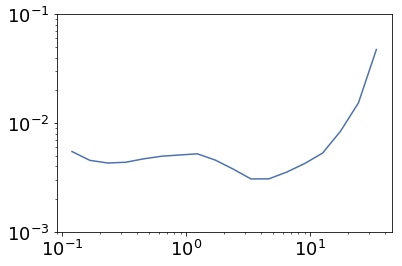

In [7]:
plt.plot(emu.scale_bin_centers, acc)
plt.ylim([1e-3, 1e-1])
plt.loglog();